# Exploratory Data Analysis

This notebook is used to conduct exploratory data analysis on the "station_lines", "systems", "tracks" and "track_lines" tables of the "city-lines" dataset with the goal of uncovering data quality issues.

## Summary

The following data quality problems were determined:

### 'station_lines' table

- 'created_at' and 'updated_at' columns have the wrong data type. As their name suggests, they are supposed to be timestamps. However they are encoded as text in both the MySQL database and Pandas. 

### 'tracks' table

- The columns 'buildstart', 'opening' and 'closure' incorrectly show up as 'float64' data types. They are also encoded as such in the database. As their name and the column values suggest, they should be YEAR or DATE. At the very least, they should be INT and not FLOAT.

- The minimum and maximum values of the 'buildstart', 'opening' and 'closure' columns are not within logical ranges. As explained above, these columns most probably denote a year. However, the lower bound of their values is -1 and the upper bound is 999999. The values that lie outside of an arbitrary range should be taken as faulty and converted to NULL.

- There are some values in the 'buildstart', "opening' and 'closure' columns that just don't make sense for the scope of our analysis today. For example, there are rows whose 'buildstart' value is >2022. They should be taken as irrelevant and converted to NULL or flagged as such through any other strategy.

- The 'length' column has no associated measurement unit information along with it. We do not know if these numbers are in CM's, M's or KM's.

- There are some values within the 'length' column that do not make sense in any measurement unit.
  
- Although it appears that there are no null values in the 'length', the rows with value 0 might as well be null.

- The 'geometry' column shows up as 'object' type in Pandas. It is also encoded as text in the database. Since it represents a geometry, it should be encoded as such.

- The geometry column lacks CRS information. As such, you cannot calculate from the geometries the length of each track. Instead you have to rely on the 'length' column.

## Setup

### Import required packages

In [5]:
from pathlib import Path
import mysql.connector as connector
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.wkt import loads

### Set credentials & establish connection with the database

In [6]:
credentials = {
    "username": "root",
    "password": ""
}

# Establish a connection with the DBMS
conn = connector.connect(user = credentials["username"],
                         passwd = credentials["password"],
                         host = "localhost",
                         database = "city-lines")

# Check if the connection is there
sql_query = """
SHOW tables;
"""
df = pd.read_sql(sql_query, conn)
df

,Tables_in_city-lines
0,cities
1,lines
2,station_lines
3,stations
4,systems
5,track_lines
6,tracks


### Load data

In [7]:
tables = {}
for table_name in ["station_lines", "systems", "tracks", "track_lines"]:
    sql_query = "SELECT * FROM {}".format(table_name)
    tables[table_name] = pd.read_sql(sql_query, conn)

## Analyze - 'station_lines' table

### Whole table

In [8]:
df = tables["station_lines"]

# Take a look at the head of the data
print(df.head(5))
print("\n")
# Generate a metadata report
print(df.info())

   id  station_id  line_id  city_id           created_at           updated_at
0   1        7694      629      114  2017-11-21 00:00:00  2017-11-21 00:00:00
1   2        6003      528       29  2017-11-21 00:00:00  2017-11-21 00:00:00
2   3        7732      570       74  2017-11-21 00:00:00  2017-11-21 00:00:00
3   4        7695      629      114  2017-11-21 00:00:00  2017-11-21 00:00:00
4   5        7726      570       74  2017-11-21 00:00:00  2017-11-21 00:00:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          16242 non-null  int64 
 1   station_id  16242 non-null  int64 
 2   line_id     16242 non-null  int64 
 3   city_id     16242 non-null  int64 
 4   created_at  16242 non-null  object
 5   updated_at  16242 non-null  object
dtypes: int64(4), object(2)
memory usage: 761.5+ KB
None


#### Table purpose and explanation
This table seems to be a 'relationship relation' table that lays out which stations lie on which lines. Inversely, it can also be used to represent the lines that pass from a station. It can also be linked to individual cities.

#### Summary

The "station_lines" table consists of six columns and 16242 rows. None of the rows have any null values, which is a good indicator. The first four columns (id, station_id, line_id and city_id) have the NumPy data type 'int64'. This makes sense as these are id's and id's are usually discrete numbers. This also means that id's are numeric only - no letters or markings at all. The last two columns (created_at and updated_at) show up as NumPy 'object' data type. This can mean anything.

#### Potential problems

- As the name of 'created_at' and 'updated_at' column suggests, these columns  were supposed to be 'time and date' data types. They did not show up in Pandas as such. This might be a problem while analyzing the data.


### 'station_id' column

In [9]:
target_col = df["station_id"]

# Number of unique values, what they are and how many times they appear
print(target_col.nunique()) # 15468 unique values
print("\n")
print(target_col.value_counts())

15468


11422    7
11258    6
10940    6
11049    6
11048    6
        ..
2308     1
2347     1
2309     1
2336     1
16558    1
Name: station_id, Length: 15468, dtype: int64


In [10]:
# What about the inverse, how many stations appear 7 times, 6 times ... 1 times etc.
result = (pd.DataFrame(target_col.value_counts())
          .rename({"station_id": "count"}, axis = 1))
result["station_id"] = result.index
result = (result
          .reset_index(drop = True)
          .groupby("count")
          .agg("count"))

print(result)

       station_id
count            
1           14851
2             502
3              91
4              13
5               5
6               5
7               1


In [11]:
# min and max of the column
print(target_col.min(), target_col.max())

1 16558


#### Column purpose and explanation
The "station_id" column seems to be a foreign key that links to "station" table.

#### Summary

There are 15468 unique stations in total. Most stations appear one time. However, some appear up to seven times.

#### Potential problems

No potential problems found.

### 'line_id' column

In [12]:
target_col = df["line_id"]

# Number of unique values, what they are and how many times they appear
print(target_col.nunique()) # 1020 unique values
print("\n")
print(target_col.value_counts())

1020


658     95
639     90
612     87
171     86
938     78
        ..
1213     1
1214     1
106      1
740      1
554      1
Name: line_id, Length: 1020, dtype: int64


In [13]:
# What about the inverse, how many stations appear 7 times, 6 times ... 1 times etc.
result = (pd.DataFrame(target_col.value_counts())
          .rename({"line_id": "count"}, axis = 1))
result["line_id"] = result.index
result = (result
          .reset_index(drop = True)
          .groupby("count")
          .agg("count"))

print(result)

       line_id
count         
1           34
2           89
3           58
4           48
5           33
...        ...
78           1
86           1
87           1
90           1
95           1

[69 rows x 1 columns]


In [14]:
# min and max of the column
print(target_col.min(), target_col.max())

5 1614


#### Column purpose and explanation

The 'line_id' column seems to be a foreign key that links to the "line" table.

#### Summary

There are 1020 unique lines in total, far less than stations as expected. The minimum and the maximum of the dataset also seems correct. The number of times that a line appears in the dataset has a more diverse distribution when compared to stations.

#### Potential problems

No potential problems found.

### 'city_id' column

In [15]:
target_col = df["city_id"]

# min and max of the column
print(target_col.min(), target_col.max())
print("\n")
# Number of unique values, what they are and how many times they appear
print(target_col.nunique()) # 81 unique values
print("\n")
print(target_col.value_counts())

1 331


81


114    3335
91     1291
206    1224
69      912
95      897
       ... 
283       4
199       3
211       2
45        1
72        1
Name: city_id, Length: 81, dtype: int64


In [16]:
# What about the inverse, how many stations appear n times, n - 1 times etc...
result = (pd.DataFrame(target_col.value_counts())
          .rename({"city_id": "count"}, axis = 1))
result["city_id"] = result.index
result = (result
          .reset_index(drop = True)
          .groupby("count")
          .agg("count"))

print(result)

       city_id
count         
1            2
2            1
3            1
4            1
5            1
...        ...
897          1
912          1
1224         1
1291         1
3335         1

[73 rows x 1 columns]


#### Column purpose and explanation

The 'city_id' column seems to be a foreign key that points to the 'cities' table.

#### Summary

The minimum id and the maximum id seems to be between logical bounds. There are 81 unique city id's in total. 

#### Potential problems

- There are 81 unique cities in total, which seems to be a problem.

### 'created_at' column

In [17]:
target_col = pd.to_datetime(df["created_at"]) # We need this as datetime

# min and max of the column
print(target_col.min(), target_col.max())
print("\n")

2017-11-21 00:00:00 2019-03-11 21:42:48.700022




#### Column purpose and explanation

The exact purpose of this column is a bit of a puzzle. It might be signalling the time that this entry was first created.

#### Summary

The min and the max values seem to be within logical bounds. Doesn't seem to be much useful for analysis purposes.

#### Potential problems

- This column needs to be of TIMESTAMP data type. It is currently text only.

### 'updated_at' column

In [18]:
target_col = pd.to_datetime(df["updated_at"]) # We need this as datetime

# min and max of the column
print(target_col.min(), target_col.max())
print("\n")

2017-11-21 00:00:00 2019-03-11 21:42:48.700022




#### Column purpose and explanation

The exact purpose of this column is a bit of a puzzle. It might be signalling the time that this entry was edited.

#### Summary

The min and the max values seem to be within logical bounds. Doesn't seem to be much useful for analysis purposes.

#### Potential problems

This column needs to be of TIMESTAMP data type. It is currently text only.

## Analyze - 'systems' table

### Whole table

In [19]:
df = tables["systems"]

# Take a look at the head of the data
print(df.head(5))
print("\n")
# Generate a metadata report
print(df.info())

   id  city_id  name
0   1        5  None
1   2        6  None
2   3        7  None
3   4        8  None
4   5        9  None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       488 non-null    int64 
 1   city_id  488 non-null    int64 
 2   name     287 non-null    object
dtypes: int64(2), object(1)
memory usage: 11.6+ KB
None


#### Table purpose and explanation

This table serves as a table that represents the "systems" entity. The systems entity has only one non-key attribute, and that is the 'name' attribute. The other two entities are id's. The 'id' column is the primary key of this table and the 'city_id' column is a foreign key that links to the 'cities' table.

#### Summary

The table has 3 columns and 488 rows. The first two columns ('id' and 'city_id') do not have any null values as they are keys. The 'name' column has nearly half of its values as NULL. The id columns are of NumPy data type int64 and the 'name' column is a NumPy object. This makes sense as the NumPy 'object' also describes text.

#### Potential problems


### 'id' column

In [20]:
target_col = df["id"]

# Check the min and max values
print(target_col.min(), target_col.max())
print("\n")

# Look at how many unique values there are and how many times they appear
print(target_col.nunique())
print("\n")
print(target_col.value_counts())

1 638


488


1      1
348    1
346    1
345    1
343    1
      ..
161    1
160    1
159    1
158    1
638    1
Name: id, Length: 488, dtype: int64


#### Column purpose and explanation

This column serves as the primary key of the 'systems' table.

#### Summary

The min and the max values seem to be within logical bounds. As expected from an id column, there are no null values and there are as many unique values as there are id's.

#### Potential problems

No potential problems found.

### 'city_id' column

In [21]:
target_col = df["city_id"]

# Check the min and max values
print(target_col.min(), target_col.max())
print("\n")

# Look at how many unique values there are and how many times they appear
print(target_col.nunique())
print("\n")
print(target_col.value_counts())
print("\n")

# What about the inverse, how many stations appear n times, n - 1 times etc...
result = (pd.DataFrame(target_col.value_counts())
          .rename({"city_id": "count"}, axis = 1))
result["city_id"] = result.index
result = (result
          .reset_index(drop = True)
          .groupby("count")
          .agg("count"))

print(result)

1 331


287


114    49
91     26
206    14
95      9
139     8
       ..
34      1
127     1
128     1
129     1
323     1
Name: city_id, Length: 287, dtype: int64


       city_id
count         
1          230
2           28
3           13
4            3
5            3
6            5
8            1
9            1
14           1
26           1
49           1


#### Column purpose and explanation

This column serves as a foreign key that links to the 'cities' table.

#### Summary

The min and the max values seem to be within logical bounds. As expected from an id column, there are no null values. Most city id's appear only once. However, some city id's appear more than once (up to 49 times). This might indicate that some cities possess a wider range of transportation systems.

#### Potential problems

No potential problems found.

### 'name' column

In [22]:
target_col = df["name"]

# Look at how many unique values there are and how many times they appear
print(target_col.nunique()) 
print("\n")
print(target_col.value_counts())
print("\n")

# What about the inverse, how many stations appear n times, n - 1 times etc...
result = (pd.DataFrame(target_col.value_counts())
          .rename({"name": "count"}, axis = 1))
result["city_id"] = result.index
result = (result
          .reset_index(drop = True)
          .groupby("count")
          .agg("count"))
print(result)

235


Tramway                                16
Metro                                  13
Tram                                    9
Métro                                   3
Funiculaire                             3
                                       ..
Tokyo Monorail                          1
Macrobús                                1
Tokyo Waterfront Area Rapid Transit     1
Comboios de Portugal                    1
Ómnibus                                 1
Name: name, Length: 235, dtype: int64


       city_id
count         
1          219
2            9
3            4
9            1
13           1
16           1


#### Column purpose and explanation

This column is the only non-key attribute of the 'systems' table. It gives information about what a transportation system is called in the local language.

#### Summary

There appears to be some universal names (like "Tramway" and "Metro") that appear more than once. Other than that, there aren't any exactly equal names. This table is not suitable to be used in the analysis of transportation system diversity because the systems with the same technical classification might be named or spelled differently in different languages.

#### Potential problems

No potential problems found.

## Analyze 'tracks' table

### Whole table

In [23]:
df = tables["tracks"]

# Take a look at the head of the data
print(df.head(5))
print("\n")
# Generate a metadata report
print(df.info())

   id                                           geometry  buildstart  opening  \
0   1  LINESTRING(-58.3709571211488 -34.6088372926399...      1911.0   1913.0   
1   2  LINESTRING(-58.4068664851857 -34.6097834143688...      1911.0   1914.0   
2   3  LINESTRING(-58.4412952642446 -34.6204610313281...      2004.0   2008.0   
3   4  LINESTRING(-58.4566866633175 -34.6266601195794...      2004.0   2013.0   
4   5  LINESTRING(-58.4551967550169 -34.5871909624797...      1928.0   1930.0   

    closure  length  city_id  
0  999999.0    3334        1  
1       NaN    3459        1  
2       NaN    1571        1  
3       NaN    1272        1  
4       NaN    6382        1  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9271 entries, 0 to 9270
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          9271 non-null   int64  
 1   geometry    9271 non-null   object 
 2   buildstart  7663 non-null   float64
 3   opening  

Another layer of analysis is needed to uncover this table. Since this table includes geometry information, it is better to turn it into a geodataframe.

In [24]:
# Convert df into a GeoDataFrame
df = gpd.GeoDataFrame(df, crs = "EPSG:3035")
df.geometry = df["geometry"].apply(loads)
print(df.head(5))
print("\n")

C:\Users\ejgen\AppData\Local\Temp/ipykernel_11124/2769002287.py:2: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  df = gpd.GeoDataFrame(df, crs = "EPSG:3035")


   id                                           geometry  buildstart  opening  \
0   1  LINESTRING (-58.37096 -34.60884, -58.37212 -34...      1911.0   1913.0   
1   2  LINESTRING (-58.40687 -34.60978, -58.40710 -34...      1911.0   1914.0   
2   3  LINESTRING (-58.44130 -34.62046, -58.44311 -34...      2004.0   2008.0   
3   4  LINESTRING (-58.45669 -34.62666, -58.45791 -34...      2004.0   2013.0   
4   5  LINESTRING (-58.45520 -34.58719, -58.45160 -34...      1928.0   1930.0   

    closure  length  city_id  
0  999999.0    3334        1  
1       NaN    3459        1  
2       NaN    1571        1  
3       NaN    1272        1  
4       NaN    6382        1  




EPSG:3035


0       LINESTRING (-58.37096 -34.60884, -58.37212 -34...
1       LINESTRING (-58.40687 -34.60978, -58.40710 -34...
2       LINESTRING (-58.44130 -34.62046, -58.44311 -34...
3       LINESTRING (-58.45669 -34.62666, -58.45791 -34...
4       LINESTRING (-58.45520 -34.58719, -58.45160 -34...
                              ...                        
9266    LINESTRING (136.19464 35.11437, 136.19382 35.1...
9267    LINESTRING (136.26367 35.27216, 136.26411 35.2...
9268    LINESTRING (136.21952 35.01229, 136.21950 35.0...
9269    LINESTRING (136.26071 35.23662, 136.26111 35.2...
9270    LINESTRING (136.15392 34.95203, 136.15580 34.9...
Name: geometry, Length: 9271, dtype: geometry




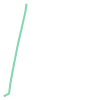

In [25]:
# Does it have CRS encoded?
print(df.crs)
print("\n")
# What about a geometry?
print(df.geometry)
print("\n")
# Plot one line to see if it works
df["geometry"][50]

#### Table purpose and explanation

This table serves as a table that represents the "tracks" entity. A track is a specific subset of a line. Each line is made up of many tracks. You can connect individual lines with their tracks using the 'lines', 'tracks' and 'tracks_lines' tables. The table has one primary key ('id' column) and a foreign key ('city_id' column). The foreign key links to the 'cities' table. The 'geometry' column is also of crucial importance because it includes geometry information about a track in form of linestring.

#### Summary

The table has seven columns and 9271 rows in total. The most crucial columns ('id', 'geometry', 'length' and 'city_id' columns) have no null values whereas the other columns do have some null values.

#### Potential problems

- The columns 'buildstart', 'opening' and 'closure' incorrectly show up as 'float64' data types. They are also encoded as such in the database. Converting these into YEAR or DATETIME values would be better.

- The 'geometry' column shows up as 'object' type in Pandas. It is also encoded as text in the database. Since it represents a geometry, it should be encoded as such.

### 'id' column

In [26]:
target_col = df["id"]

# Check the min and max values
print(target_col.min(), target_col.max())
print("\n")

# Look at how many unique values there are and how many times they appear
print(target_col.nunique())
print("\n")
print(target_col.value_counts())

1 10534


9271


1        1
7211     1
7157     1
7158     1
7159     1
        ..
3478     1
3479     1
3480     1
3481     1
10534    1
Name: id, Length: 9271, dtype: int64


#### Column purpose and explanation

This column serves as the primary key of the 'tracks' table.

#### Summary

As expected, there as as many unique values as there are values in the series.

#### Potential problems

No potential problems found.

### 'geometry' column

In [27]:
target_col = df.geometry

# Check the min line length and max line length
min = (df.geometry.length).min()
max = (df.geometry.length).max()
print(min, max)
print("\n")
# There seems to be a problem. Let's skip ahead and compare this with the "length" columns
length_comp = pd.DataFrame({"length-orig": df["length"],
                            "length-calc": df.geometry.length})
print(length_comp.head())
print("\n")
# The lengths don't match. This is most possibly due to a CRS fuckup.

0.0 1.572434750932568


   length-orig  length-calc
0         3334     0.036210
1         3459     0.036721
2         1571     0.016599
3         1272     0.013582
4         6382     0.067544




#### Column purpose and explanation

This column contains the information about the actual geometry of the tracks. It can be used alongside GeoPandas to plot the lines.

#### Summary

I couldn't find a suitable CRS that would give me the lengths as stated by the 'length' column.

#### Potential problems

- The length as calculated through playing with the geometries and the length as stated by the 'length' column may not match.

### 'buildstart' column

In [28]:
target_col = (df["buildstart"])

# Get the 'min' value and the 'max' value
print(target_col.min(), target_col.max())
print("\n")
# The 'min' value and the 'max' value seem to problematic. -1 is not a valid date, neither is 9999999 yet.

-1.0 999999.0




In [29]:
target_col = target_col.sort_values(ascending = True)
print(target_col.head(10)) # -1 and 0 aren't valid dates
print("\n")

target_col = target_col.sort_values(ascending = False)
print(target_col.head(10)) # 99999.. and 19160 aren't valid dates. Also 2025 and 2023?
print("\n")

3197   -1.0
6790   -1.0
4561    0.0
7136    0.0
7135    0.0
7134    0.0
7133    0.0
7132    0.0
7131    0.0
7130    0.0
Name: buildstart, dtype: float64


2392    999999.0
2393    999999.0
908     999999.0
1601    999999.0
1602    999999.0
901     999999.0
899     999999.0
1174     19160.0
7997      2025.0
3316      2023.0
Name: buildstart, dtype: float64




In [30]:
# Get the number of unique values and what they are
print(target_col.nunique()) # 193 values make sense since the years ought to repeat
print("\n")
print(target_col.value_counts()) # Here's a big problem: 0.0 repeats a lot of times. Should be null. Also 2025 and 19160?
print("\n")

193


0.0        3107
2011.0      184
2009.0      174
2010.0      138
2000.0      109
           ... 
1947.0        1
1851.0        1
19160.0       1
2023.0        1
2025.0        1
Name: buildstart, Length: 193, dtype: int64




#### Column purpose and explanation

This column serves to give information about the date on which the building efforts for a track started.

#### Summary

There seems to be a lot of noise in this dataset. Most of the datapoints have the correct values (in between 1850 and 202n). However, some data points have absurd values.

#### Potential problems

- The data type of this column should be YEAR, not float.
- The minimum value and the maximum values are nonsensical. There is -1, 0, 19160 and 999....
- Some dates are probable, but not reached yet: 2023, 2025.
- Null values are encoded in different ways: as 9999, as 0 and as -1.

### 'opening' column

In [31]:
target_col = (df["opening"])

# Get the 'min' value and the 'max' value
print(target_col.min(), target_col.max())
# The 'min' value and the 'max' value seem to problematic. 0 is not a valid date, neither is 9999999 yet.

0.0 999999.0


In [32]:
target_col = target_col.sort_values(ascending = True)
print(target_col.head(10)) # 0 isn't a valid date.
print("\n")

target_col = target_col.sort_values(ascending = False)
print(target_col.head(10)) # 99999 isn't a valid date.
print("\n")

4637    0.0
7241    0.0
7240    0.0
7239    0.0
7238    0.0
7237    0.0
7236    0.0
7235    0.0
7234    0.0
7233    0.0
Name: opening, dtype: float64


8250    999999.0
8193    999999.0
899     999999.0
905     999999.0
908     999999.0
8261    999999.0
5742    999999.0
2392    999999.0
2393    999999.0
8264    999999.0
Name: opening, dtype: float64




In [33]:
print(target_col.nunique()) # 193 values make sense since the years ought to repeat
print("\n")
print(target_col.value_counts()) # Here's a big problem: 0.0 repeats a lot of times. Should be null. 99999 and 99999 are also invalid
print("\n")

197


0.0        2908
2007.0      312
2014.0      306
2000.0      301
2012.0      234
           ... 
99999.0       1
1843.0        1
20008.0       1
9999.0        1
2027.0        1
Name: opening, Length: 197, dtype: int64




#### Column purpose and explanation

This column serves to give information about the date on which the building efforts for a track ended.

#### Summary

There seems to be a lot of noise in this dataset. Most of the datapoints have the correct values (in between 1850 and 202n). However, some data points have absurd values.

#### Potential problems

- The data type of this column should be YEAR, not float.
- The minimum value and the maximum values are nonsensical. There is 0, 19160 and 999....
- Some dates are probable, but not reached yet: 2027
- Null values are encoded in different ways: as 9999 and as 0

### 'closure' column

In [34]:
target_col = (df["closure"])

# Get the 'min' value and the 'max' value
print(target_col.min(), target_col.max())
print("\n")
# The 'min' value and the 'max' value seem to problematic. 99999 is not a valid date.

target_col = target_col.sort_values(ascending = True)
print(target_col.head(10)) # Seems OK
print("\n")

target_col = target_col.sort_values(ascending = False)
print(target_col.head(10)) # 99999 isn't a valid date.
print("\n")

print(target_col.nunique())
print("\n")
print(target_col.value_counts()) # Lots of 99999999
print("\n")



1882.0 999999999.0


219     1882.0
4018    1883.0
209     1886.0
7222    1889.0
7304    1889.0
7218    1889.0
7998    1893.0
4201    1894.0
4011    1894.0
4202    1894.0
Name: closure, dtype: float64


924     999999999.0
4001      9999999.0
471        999999.0
493        999999.0
478        999999.0
476        999999.0
475        999999.0
474        999999.0
473        999999.0
472        999999.0
Name: closure, dtype: float64


123


999999.0     8451
1972.0         50
1969.0         47
1971.0         46
1968.0         44
             ... 
9999999.0       1
1960.0          1
1957.0          1
1927.0          1
1882.0          1
Name: closure, Length: 123, dtype: int64




#### Column purpose and explanation

This column serves to give information about the date on which a track was closed

#### Summary

There seems to be a lot of noise in this dataset. Most of the datapoints have the correct values (in between 1850 and 202n). However, some data points have absurd values.

#### Potential problems

- The data type of this column should be YEAR, not float.
- The maximum values are nonsensical. We have a lot of 9999's and 99999999
- Some dates are probable, but not reached yet: 2027
- Null values are encoded in different ways: as 9999 and as 0

### 'length' column

In [35]:
target_col = df["length"]

# Get the min and the max
print(target_col.min(), target_col.max()) # 0 doesn't really make sense?
print("\n")

target_col = target_col.sort_values(ascending = True)
print(target_col.head(10)) # 0 and 1 doesn't make sense.
print("\n")

under_100_mask = target_col < 100
print(target_col[under_100_mask]) # Lots of values under 100
print("\n")

target_col = target_col.sort_values(ascending = False)
print(target_col.head(10)) # Seems OK
print("\n")


0 148768


1267    0
7634    0
6653    0
1422    0
6403    1
2495    1
2492    1
4560    1
7709    1
566     1
Name: length, dtype: int64


1267     0
7634     0
6653     0
1422     0
6403     1
        ..
4895    99
6325    99
2069    99
2609    99
4531    99
Name: length, Length: 2080, dtype: int64


4009    148768
4302     93331
1456     82543
3553     77337
8130     68082
3994     66217
4801     64307
8197     62113
3535     61770
3316     61027
Name: length, dtype: int64




In [36]:

print(target_col.nunique())
print("\n")
print(target_col.value_counts()) # The number of unique values seems a little low.
print("\n")

3788


21      42
26      39
32      39
11      38
19      36
        ..
4578     1
4577     1
4576     1
4574     1
2509     1
Name: length, Length: 3788, dtype: int64




#### Column purpose and explanation

This column contains the length of each track in an unknown measurement type (cm? m? km?)

#### Summary

There seems to be a lot of noise in this dataset. Some values seems unlikely (0, 1 aswell as 148768).

#### Potential problems

- What is the measure of length? centimeters? kilometers?
- The minimum values and the maximum values are nonsensical
- Althought it initially appears as there aren't any null values, rows with the value 0 might aswell be null.

### 'city_id' column

Skipping as this column is a foreign key and possible has no problems.

## Analyze "track_lines" column

### Whole table

In [38]:
df = tables["track_lines"]

# Look at the first few lines
print(df.head(5))
print("\n")
# Generate a metadata report
print(df.info())

   id  section_id  line_id           created_at           updated_at  city_id
0   1        1911      530  2017-11-21 00:00:00  2017-11-21 00:00:00       29
1   2        2563      154  2017-11-21 00:00:00  2017-11-21 00:00:00      118
2   3        2557      154  2017-11-21 00:00:00  2017-11-21 00:00:00      118
3   4        2558      154  2017-11-21 00:00:00  2017-11-21 00:00:00      118
4   5        2564      154  2017-11-21 00:00:00  2017-11-21 00:00:00      118


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9757 entries, 0 to 9756
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          9757 non-null   int64 
 1   section_id  9757 non-null   int64 
 2   line_id     9757 non-null   int64 
 3   created_at  9757 non-null   object
 4   updated_at  9757 non-null   object
 5   city_id     9757 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 457.5+ KB
None


#### Table purpose and explanation

I have no idea what purpose this table serves. It connects through foreign keys to the 'city' and 'line' tables, but the information that it contains in itself is only the 'section_id' column which does not connect to any table.

#### Summary

The table has six columns and 9757 entries. There are no null values.

#### Potential problems

No potential problems found.